In [1]:
from Utils.FS import file
from nltk.tokenize.punkt import PunktSentenceTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import brown
from scipy.sparse import coo_matrix, dok_matrix
from scipy.sparse.linalg import svds
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE

In [2]:
np.random.seed(1234)
WINDOW_SIZE = 5
NORM = 'l2'
SVD_DIMENSION = 2

In [3]:
sents = brown.sents()
sents = [[token.lower() for token in sent] for sent in sents]
words = brown.words()
words = [word.lower() for word in words]

In [4]:
print("Number of tokens: {}".format(len(words)))
print("Number of sentences: {}".format(len(sents)))
print("Longest sentences length: {}".format(max([len(sent) for sent in sents])))

Number of tokens: 1161192
Number of sentences: 57340
Longest sentences length: 180


In [5]:
def words2dicts(words):
    f_dict = {}
    index = 0
    for word in words:
        if not word in f_dict.keys():
            f_dict[word] = index
            index = index + 1
        
    return f_dict, { v:k for k, v in f_dict.items()}

In [6]:
words_dict, inv_words_dict = words2dicts(words)
words_size = len(words_dict)
print("Number of unique tokens: {}".format(words_size))

Number of unique tokens: 49815


In [7]:
def sents2wordContextMatrix(sents, words_dict, window = 5):
    m = coo_matrix((words_size, words_size), 'float64')
    
    print('Doing forward pass...')
    back = []
    row = []
    col = []
    data = []
    for sent in sents:
        for word in sent:
            row += [words_dict[word] for b in back]
            col += [words_dict[b] for b in back]
            data += [1 for b in back]
            if len(back) == window:
                back.pop(0)
            back.append(word)
    
    print('Doing backward pass...')
    back = []
    for sent in reversed(sents):
        for word in reversed(sent):
            row += [words_dict[word] for b in back]
            col += [words_dict[b] for b in back]
            data += [1 for b in back]
            if len(back) == window:
                back.pop(0)
            back.append(word)
    
    return coo_matrix((data, (row, col)), shape=(words_size, words_size), dtype='float64')

In [8]:
def sents2freq(sents):
    freq = {}
    for sent in sents:
        for word in sent:
            if word in freq.keys():
                freq[word] += 1
            else:
                freq[word] = 1
    return freq

words_freq = sents2freq(sents)

In [9]:
m = sents2wordContextMatrix(sents, words_dict, WINDOW_SIZE)

Doing forward pass...
Doing backward pass...


In [61]:
m.tocsr()[0].todense()[0, 0]
inv_words_dict[0]

'the'

In [10]:
norm_m = normalize(m, norm=NORM, axis=1, copy=True, return_norm=False)

In [42]:
u, s, vt = svds(norm_m, k=SVD_DIMENSION)
#u, s, vt = svds(m, k=SVD_DIMENSION)

#norm_u = normalize(u, norm=NORM, axis=1, copy=True, return_norm=False)

words_vec = {}
for i in range(u.shape[0]):
    words_vec[inv_words_dict[i]] = u[i]
print(words_vec['man'])

[ 0.00018687  0.00767021]


In [43]:
def plotData(vocabs, X, Y):
    plt.scatter(X, Y)
    plt.axis([min(X), max(X), min(Y), max(Y)])
    for label, x, y in zip(vocabs, X, Y):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.show()    

In [44]:
def plot(vocabs, words_vec):
    X = [words_vec[vocab][0] for vocab in vocabs]
    Y = [words_vec[vocab][1] for vocab in vocabs]
    plotData(vocabs, X, Y)

In [45]:
def plotTSNE(vocabs, words_vec):
    tsne = TSNE(n_components=2, random_state=0)
    #np.set_printoptions(suppress=True)
    data = np.array([words_vec[vocab] for vocab in vocabs])
    print(data.shape)
    DATA = tsne.fit_transform(data)
    X = DATA[:, 0]
    Y = DATA[:, 1]
    
    plotData(vocabs, X, Y)

In [46]:
vocabs = ['man', 'woman', 'king', 'queen', 'male', 'female', 'boy', 'girl']

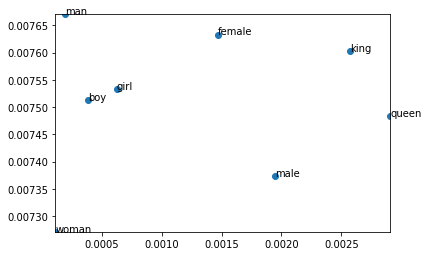

In [47]:
plot(vocabs, words_vec)

In [17]:
from DataLoader import GloVe

glove = GloVe.load2('./data/GloVe/glove.6B.50d.txt')

Start: Loading Glove Model
End: Loaded 400000 rows.


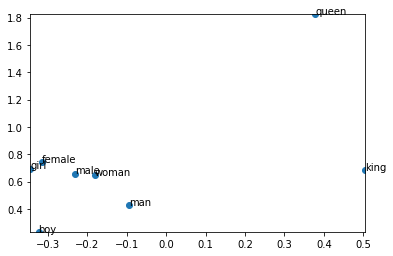

In [18]:
vocabs = ['man', 'woman', 'king', 'queen', 'male', 'female', 'boy', 'girl']
plot(vocabs, glove)

(8, 50)


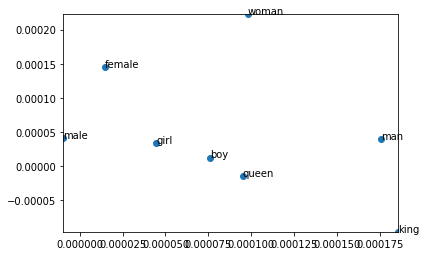

In [19]:
plotTSNE(vocabs, glove)